# MNIST Practice

## Goals
* Use PyTorch to do a somewhat basic classifier

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2

from torch.utils.data import DataLoader

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
num_labels = 10 # for for each digit

num_epochs = 100

In [3]:
# Check the device information
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Getting the data


In [4]:
# old
#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.5,),(0.5)) # map data set from 0-255 to -1 to 1
#])
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=[0.5],std=[0.5]), # map data set from 0-255 to -1 to 1
    v2.ElasticTransform(alpha = 50.0,sigma = 5.0,fill = -1) # apply elastic deformation
])


os.makedirs('data_train',exist_ok=True)

# Need to verify that the training and other datasets are non-overlapping

# torchvision.datasets.MNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)
mnist_set = torchvision.datasets.MNIST(root="data_train",train=True,download=True,transform=transform)


# Separate transforms for the testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5)) # map data set from 0-255 to -1 to 1
])

os.makedirs('data_test',exist_ok=True)
mnist_set_test = torchvision.datasets.MNIST(root="data_test",train=False,download=True,transform=transform_test)



/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


100%|██████████| 9912422/9912422 [00:00<00:00, 81892892.52it/s]


Extracting data_train/MNIST/raw/train-images-idx3-ubyte.gz to data_train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 110930122.55it/s]

Extracting data_train/MNIST/raw/train-labels-idx1-ubyte.gz to data_train/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19742429.18it/s]


Extracting data_train/MNIST/raw/t10k-images-idx3-ubyte.gz to data_train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11199605.39it/s]


Extracting data_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 76453063.76it/s]


Extracting data_test/MNIST/raw/train-images-idx3-ubyte.gz to data_test/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41062947.06it/s]


Extracting data_test/MNIST/raw/train-labels-idx1-ubyte.gz to data_test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 18799364.46it/s]


Extracting data_test/MNIST/raw/t10k-images-idx3-ubyte.gz to data_test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8075679.85it/s]

Extracting data_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_test/MNIST/raw



In [5]:
# Data Loader
batch_size = 32
mnist_loader      = DataLoader(dataset=mnist_set,batch_size=batch_size,shuffle=True)
mnist_loader_test = DataLoader(dataset=mnist_set_test,batch_size=batch_size,shuffle=True)

num_batches = len(mnist_loader)
num_batches_test = len(mnist_loader_test)

print(f"Have {num_batches} training batches and {num_batches_test} testing batches.")

Have 1875 training batches and 313 testing batches.


# Printing Examples

tensor([3, 4, 8, 5, 7, 9, 7, 1, 6, 4, 6, 4, 8, 9, 0, 1, 0, 4, 2, 7, 0, 1, 9, 5,
        1, 8, 0, 6, 0, 1, 6, 9])
torch.Size([32, 1, 28, 28])
tensor([-1.0000, -0.7514, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -0.9198, -0.0452,  0.8690,  0.9765,  0.9769,
         0.9822,  0.9765,  0.9765,  0.9765,  0.9765,  0.8509,  0.0579, -0.8337,
        -1.0000, -1.0000, -1.0000, -0.7584])
28


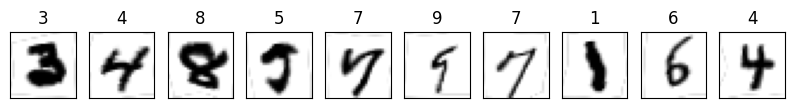

In [6]:
train_features, train_labels = next(iter(mnist_loader))
print(train_labels)
print(train_features.shape)
print(train_features[0][0][13])

image_size = train_features.shape[2]
print(image_size)

num_to_plot = 10
fig, ax = plt.subplots(1,num_to_plot,figsize=(10,5))
for i in range(num_to_plot):
    ax[i].imshow(train_features[i].squeeze(),cmap='binary')
    ax[i].set_title(train_labels[i].item())
    ax[i].set_xticks([])
    ax[i].set_yticks([])

tensor([9, 9, 9, 7, 3, 8, 1, 7, 1, 1, 0, 5, 0, 8, 6, 8, 4, 5, 1, 5, 2, 2, 4, 7,
        5, 9, 7, 1, 8, 6, 3, 2])
torch.Size([32, 1, 28, 28])
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.0980,  0.9843,
         0.9843,  0.2784, -0.9373, -1.0000, -1.0000, -1.0000, -1.0000,  0.9529,
         0.9843,  0.9843,  0.9843,  0.8275, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000])
28


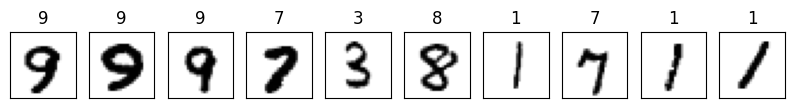

In [7]:
# repeat the same for the testing/validation

train_features, train_labels = next(iter(mnist_loader_test))
print(train_labels)
print(train_features.shape)
print(train_features[0][0][13])

image_size = train_features.shape[2]
print(image_size)

num_to_plot = 10
fig, ax = plt.subplots(1,num_to_plot,figsize=(10,5))
for i in range(num_to_plot):
    ax[i].imshow(train_features[i].squeeze(),cmap='binary')
    ax[i].set_title(train_labels[i].item())
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [8]:
#count = 0
#for batch in mnist_loader:
#    images, labels = batch
#    break


## Planning Notes
* Should use a neural network with 10 output nodes, linear output. This gets plugged into the the logistic function, giving the probability for each.
* What about normalizing the output so that each output, after applying the logistic function

In [9]:
# useful for one-hot encoding the truth variables
# identity_tensor = torch.eye(num_labels)


# from this: https://neuralthreads.medium.com/categorical-cross-entropy-loss-the-most-important-loss-function-d3792151d05b
# it seems like there is potential for optimization by explicitly giving the analytical 

debug_cat = False
# mimicking the from_logits variable from TF
#
def CatCrossEntropy(result,truth,from_logits=True):
    """
     Args:
        result (tensor): Results from the model, to be compared to the truth (batch_dim,num_labels)
        truth (tensor): Target of the model (batch_dim,)
        from_logits (bool): If true, assume linear input. If false, assume logistic function already applied
 
    """
    if (debug_cat):
        print(result)
        print(truth)
    batch_size = result.shape[0]
    total = 0
    if from_logits:
        softmaxed_input = torch.softmax(result,dim=-1) # apply along the last dimension
    else:
        softmaxed_input = result
    if debug_cat:
        print("Sum of softmax")
        print(torch.sum(softmaxed_input,dim=1))
        
    #log_truth = torch.log(truth)
    # encode truth as one-hot
    truth_one_hot = torch.zeros((batch_size,num_labels)).to(device)
    # would it be faster to have one tensor that is always on the device?
    for i in range(batch_size):
        truth_val = int(truth[i])
        truth_one_hot[i][truth_val] = 1.0
    if debug_cat:
        print("Tensors to multiply")
        print(softmaxed_input)
        print(truth_one_hot)
    
    # sum up -truth_one_hot * log(softmax_input)
    total = - torch.sum(truth_one_hot*torch.log(softmaxed_input),dim=[1])
    # sum up over batch
    total = torch.sum(total,dim=[0])
    
    return total


test_tensor1 = torch.tensor([[0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,],
                             [0.,0.,0.,0.,0.,5.,0.,0.,0.,0.5,],
                             [0.5,0.5,0.5,0.5,0.5,5.,0.5,0.5,0.5,0.5,]],requires_grad=True) # mimicking a linear output
test_tensor2 = torch.tensor([5,5,5]) # mimicking a truth label
#load to device
test_tensor1 = test_tensor1.to(device)
test_tensor2 = test_tensor2.to(device)

test_entropy = CatCrossEntropy(test_tensor1,test_tensor2)
print(type(test_entropy))
print(test_entropy)

<class 'torch.Tensor'>
tensor(4.6169, grad_fn=<SumBackward1>)


## Buiding the Model

In [10]:
debug_nn = False


class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,12,(3,3),padding='same',padding_mode='replicate')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12,24,(3,3))
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(864,200),
            nn.ReLU(),
            nn.Linear(200,100),
            nn.ReLU(),
            nn.Linear(100,10),
        )
    def forward(self,x):
        #x = x.squeeze() 
        # note: Conv2d normally pads with 0s. But the empty value in the images is now -1.
        if (debug_nn):
            print(x.shape)
        x = F.relu(self.conv1(x))
        if (debug_nn):
            print(x.shape)
        x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        if (debug_nn):
            print(x.shape)
        x = self.linear_relu_stack(x)
        return x
    
    

In [11]:
torch.manual_seed(0)
model = MyNeuralNetwork().to(device)
print(model)

MyNeuralNetwork(
  (conv1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=replicate)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=864, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [12]:
from torch.optim.lr_scheduler import ExponentialLR

In [13]:
#criterion = nn.MSELoss()
criterion = CatCrossEntropy
optimizer = optim.SGD(model.parameters(), lr=0.005)
scheduler = ExponentialLR(optimizer, gamma=0.995)
num_epochs = 10

In [14]:
print_steps = 1
print_steps_batch = 5

# note that this is currently saved at the batch level, not the epoch
loss_train_list = []
lr_list = []
for epoch in range(num_epochs):
    batch_count = 0
    #for images,labels in mnist_loader:
    for batch_id, batch in enumerate(mnist_loader):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        #images, labels = batch
        model.train()
        output = model(images)
        
        loss = criterion(output,labels).to(device)
        loss_train_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lr_list.append(scheduler.get_last_lr())
        
        if (batch_id + 1) % (print_steps_batch) == 0:
            progress = 100.0 * batch_id / num_batches
            print(f"Epoch {epoch+1}, batch {batch_id + 1}. progress {progress:.2f}%, Loss: {loss.item():.4f}",end='\r')
        
        #batch_count += 1
    if (epoch + 1) % print_steps == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
        
    scheduler.step() # try stepping the schedulear at the epoch level
        


Epoch 1, Loss: 2.0864
Epoch 2, Loss: 2.3117
Epoch 3, Loss: 0.5236
Epoch 4, Loss: 0.1803
Epoch 5, Loss: 2.4119
Epoch 6, Loss: 9.9397
Epoch 7, Loss: 0.0289
Epoch 8, Loss: 0.0147
Epoch 9, Loss: 0.0472
Epoch 10, Loss: 4.2520


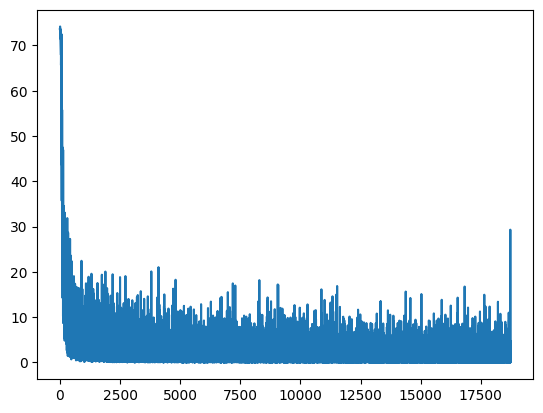

In [15]:
plt.plot(loss_train_list)

In [16]:
# run a test with the training data
train_features_local, train_labels_local = next(iter(mnist_loader))
train_features = train_features_local.to(device)
train_labels   = train_labels_local.to(device)


tensor([1, 1, 2, 4, 1, 1, 2, 4, 6, 8, 1, 8, 9, 6, 7, 2, 3, 1, 1, 1, 3, 3, 0, 8,
        0, 8, 1, 7, 0, 0, 6, 6])
tensor([1, 1, 2, 4, 1, 1, 2, 4, 6, 8, 1, 8, 9, 6, 7, 2, 3, 1, 1, 1, 3, 3, 0, 8,
        0, 8, 1, 7, 0, 0, 6, 6])


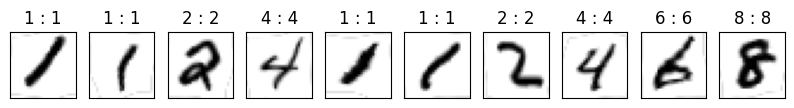

In [17]:
with torch.no_grad():
    model.eval()
    output = model(train_features)
    output = torch.softmax(output,dim=-1)
    output = torch.argmax(output,dim=-1)
    output_local = output.cpu()
    print(output)
    print(train_labels)
    
num_to_plot = 10
fig, ax = plt.subplots(1,num_to_plot,figsize=(10,5))
for i in range(num_to_plot):
    
    
    ax[i].imshow(train_features_local[i].squeeze(),cmap='binary')
    ax[i].set_title(f"{train_labels_local[i].item()} : {output_local[i].item()}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [18]:
# Test

# Data Loader
batch_size = 32
#mnist_loader_test = DataLoader(dataset=mnist_set_test,batch_size=batch_size,shuffle=True)



In [19]:
# run a test with the test loader
# run a test with the training data
train_features_local, train_labels_local = next(iter(mnist_loader_test))
train_features = train_features_local.to(device)
train_labels   = train_labels_local.to(device)


tensor([7, 2, 6, 9, 5, 3, 1, 2, 6, 5, 3, 8, 2, 7, 2, 9, 1, 2, 6, 7, 8, 0, 5, 8,
        2, 2, 0, 3, 8, 4, 1, 7])
tensor([7, 2, 6, 9, 5, 3, 1, 2, 6, 5, 3, 8, 2, 7, 2, 9, 1, 2, 6, 7, 8, 0, 5, 8,
        2, 2, 0, 3, 8, 4, 1, 7])


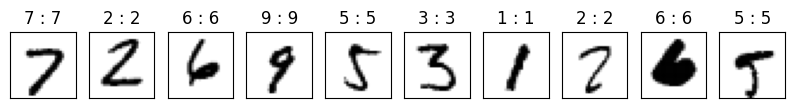

In [20]:
with torch.no_grad():
    model.eval()
    output = model(train_features)
    output = torch.softmax(output,dim=-1)
    output = torch.argmax(output,dim=-1)
    output_local = output.cpu()
    print(output)
    print(train_labels)
    
num_to_plot = 10
fig, ax = plt.subplots(1,num_to_plot,figsize=(10,5))
for i in range(num_to_plot):
    
    
    ax[i].imshow(train_features_local[i].squeeze(),cmap='binary')
    ax[i].set_title(f"{train_labels_local[i].item()} : {output_local[i].item()}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## Evaluation


In [21]:
total_count = 0
correct_count = 0
# for debugging:
incorrect_count = 0

#batch_size

#temp_cutoff = 300

for images_local,labels_local in mnist_loader_test:
    #if total_count > temp_cutoff:
    #    break
    with torch.no_grad():
        images = images_local.to(device)
        labels = labels_local.to(device)
        #images, labels = batch
        model.eval()
        output = model(images)
        output = torch.softmax(output,dim=-1)
        output = torch.argmax(output,dim=-1)
        output_local = output.cpu()
        #print(output)
        #print(labels_local)
        
        total_count += output_local.shape[0]
        # probably a more efficient way to do this
        
        comparison = torch.eq(output,labels)
        #print(comparison)
        comparison_sum = torch.sum(comparison)
        #print(comparison_sum)
        correct_count += comparison_sum.item()
        incorrect_count += (labels.shape[0] - comparison_sum.item())
        
        #for i in output_local.shape[0]:
            #if torch.equal(output_local[i],
print(f"Total: {total_count}, Correct: {correct_count}, Incorrect: {incorrect_count}")
print(f"Accuracy: {1.0*correct_count / total_count}")
print(f"Error rate: {1.0*incorrect_count / total_count}")


Total: 10000, Correct: 9909, Incorrect: 91
Accuracy: 0.9909
Error rate: 0.0091
